## Загружаем необходимые библиотеки

In [1]:
import os

import random
import pandas as pd
import numpy as np
import shutil
from tqdm import tqdm

import matplotlib
import plotly
import PIL
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import yaml
import torch
import json
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET

from sklearn.model_selection import train_test_split

Загрузка YOLO5

In [2]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16088, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 16088 (delta 10), reused 11 (delta 1), pack-reused 16056
Receiving objects: 100% (16088/16088), 14.72 MiB | 7.02 MiB/s, done.
Resolving deltas: 100% (11042/11042), done.
/content/yolov5


In [3]:
%cd /content/yolov5

!pip install -qr requirements.txt
!pip install -q roboflow

/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 654.0/654.0 kB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.1.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.2

## Загрузка датасета

Также посмотрим количество изображений в датасете и часть из них визуализируем





In [4]:
!git clone 'https://github.com/MelnikDM/Construction.git'

Cloning into 'Construction'...
remote: Enumerating objects: 19307, done.
remote: Counting objects: 100% (5747/5747), done.
remote: Compressing objects: 100% (2896/2896), done.
remote: Total 19307 (delta 2850), reused 5745 (delta 2848), pack-reused 13560
Receiving objects: 100% (19307/19307), 1.06 GiB | 29.43 MiB/s, done.
Resolving deltas: 100% (9777/9777), done.
Updating files: 100% (4349/4349), done.


In [5]:
images_path = '/content/yolov5/Construction/HardHat_2/data/Images'

In [6]:
images_count = np.array(os.listdir('/content/yolov5/Construction/HardHat_2/data/Images'))
print(f'Количество изображений в датасете: {images_count.shape[0]}')

Количество изображений в датасете: 2168


In [7]:
def display_multiple_img(images: np.ndarray, images_path: str, cols: int = 2):

    """ Функция для визуализации фотографий """

    assert (images.shape[0] % cols) == 0

    for imagename_pair in images.reshape(-1, cols):
        _, axs = plt.subplots(nrows = 1, ncols = cols, figsize = (10, 10))

        for ind, imagename in enumerate(imagename_pair):
            image = cv2.imread(
                os.path.join(images_path, imagename)
            )
            axs[ind].imshow(image[:,:,::-1])
            axs[ind].axis('off')

In [8]:
images_indices = np.arange(images_count.shape[0], dtype='int')
np.random.shuffle(images_indices)

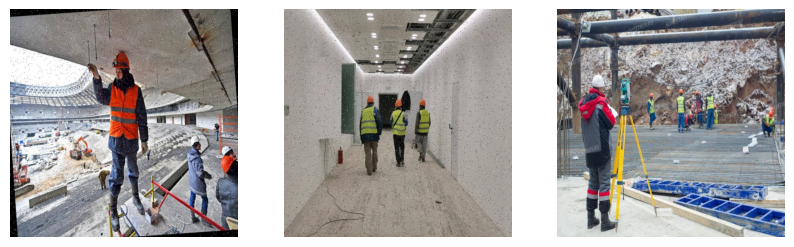

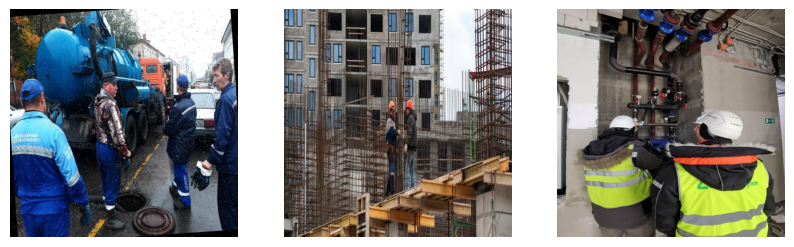

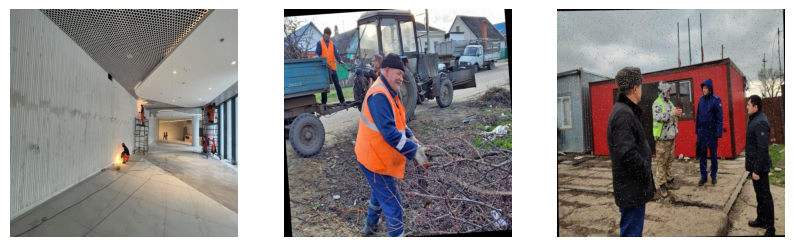

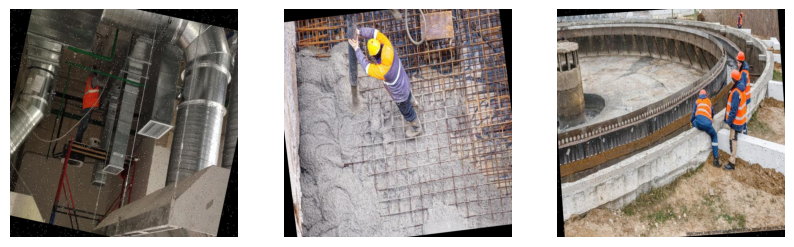

In [9]:
k = 12
first_k_images = images_count[images_indices][:k]

display_multiple_img(
    images=first_k_images,
    images_path=images_path,
    cols=3
)

In [10]:
# Размеры изображений изменены на 640х640 => aspect ratio будет равен 1.

# def get_images_metainfo(images_list: np.ndarray, images_path: str):

#     """
#        Данная функция собирает метаданные изображения
#        Результат функции это список словарей: imagename,
#        width, height, aspect_ratio
#     """

#     metainfo = []

#     for imagename in tqdm(images_list, total = images_list.shape[0]):
#         current_meta = {
#             'imagename': imagename,
#         }

#         image_path = os.path.join(images_path, imagename)
#         width, height, channels = cv2.imread(image_path).shape

#         current_meta['width'] = width
#         current_meta['height'] = height
#         current_meta['aspect_ratio'] = width/height
#         metainfo.append(current_meta)

#     return metainfo

Теперь попробуем построить heatmap с нашими баундинг боксами. Для начала "раздраконим" наш xml и сделаем из него датафрейм pandas/

In [11]:
input_folder = r"/content/yolov5/Construction/HardHat_2/data/Annotations"

# cols = ['name', 'xmin', 'ymin', 'xmax', 'ymax']

def merge_files(input_folder):
    global df2
    xml_list = []
    for file in os.listdir(input_folder):
        df = pd.read_xml(f"{input_folder}/{file}", iterparse={"object": ["name", "xmin", "ymin", "xmax", "ymax"]})
        xml_list.append(df)

    pd.set_option('display.max_columns', None)
    xml_merged = pd.concat(xml_list, ignore_index=True)
    df2 = pd.DataFrame(xml_merged)
    return df2


merge_files(input_folder)

,name,xmin,xmax,ymin,ymax
0,NoHelmet,342,356,107,117
1,Jacket,326,359,117,155
2,Helmet,346,360,157,169
3,Helmet,346,367,264,300
4,Helmet,234,277,245,300
...,...,...,...,...,...
14765,Jacket,420,426,149,160
14766,Jacket,437,443,147,156
14767,Jacket,509,515,142,154
14768,NoJacket,514,520,141,153


Попутно взглянем, как распределились наши классы

In [12]:
df2.name.value_counts()

Helmet      5509
Jacket      4105
NoJacket    2760
NoHelmet    2396
Name: name, dtype: int64

In [13]:
fig = px.bar(df2.name.value_counts().sort_index(),
             color=df2.name.value_counts().sort_index().index, opacity=0.85,
             log_y=True,
             labels={"y":"Количество аннотаций на класс", "x":""},
             title="<b>Количество аннотаций на класс</b>",)
fig.update_layout(legend_title=None,
                  xaxis_title="",
                  yaxis_title="<b>Количество аннотаций на класс</b>")

fig.show()

In [14]:
def create_fractional_bbox_coordinates(row):
    """ Данная функция вычисляет долю площади ограничивающего прямоугольника """
    img_width = 640
    img_height = 640
    frac_x_min = row["xmin"]/img_width
    frac_x_max = row["xmax"]/img_width
    frac_y_min = row["ymin"]/img_height
    frac_y_max = row["ymax"]/img_height
    return frac_x_min, frac_x_max, frac_y_min, frac_y_max

In [15]:
df2["frac_x_min"], df2["frac_x_max"], df2["frac_y_min"], df2["frac_y_max"] = \
    zip(*df2.apply(create_fractional_bbox_coordinates, axis=1))

In [16]:
df2

,name,xmin,xmax,ymin,ymax,frac_x_min,frac_x_max,frac_y_min,frac_y_max
0,NoHelmet,342,356,107,117,0.534375,0.556250,0.167187,0.182812
1,Jacket,326,359,117,155,0.509375,0.560937,0.182812,0.242188
2,Helmet,346,360,157,169,0.540625,0.562500,0.245312,0.264062
3,Helmet,346,367,264,300,0.540625,0.573438,0.412500,0.468750
4,Helmet,234,277,245,300,0.365625,0.432812,0.382812,0.468750
...,...,...,...,...,...,...,...,...,...
14765,Jacket,420,426,149,160,0.656250,0.665625,0.232813,0.250000
14766,Jacket,437,443,147,156,0.682813,0.692187,0.229687,0.243750
14767,Jacket,509,515,142,154,0.795312,0.804688,0.221875,0.240625
14768,NoJacket,514,520,141,153,0.803125,0.812500,0.220312,0.239063


Создадим столбец **classes**, в который закодируем в виде номера метку. А затем сгенерируем словарь **class_id**, который позволит нам перевести числовые метки обратно в их соответствующие строковые представления.

In [17]:
classes = {'Helmet':0,'NoHelmet':1, 'NoJacket':2, 'Jacket':3}

df2['classes'] = df2['name'].map(classes)

In [18]:
class_id = {i:df2[df2["classes"]==i].iloc[0]["name"] for i in range(4)}

100%|██████████| 14770/14770 [00:00<00:00, 27650.93it/s]


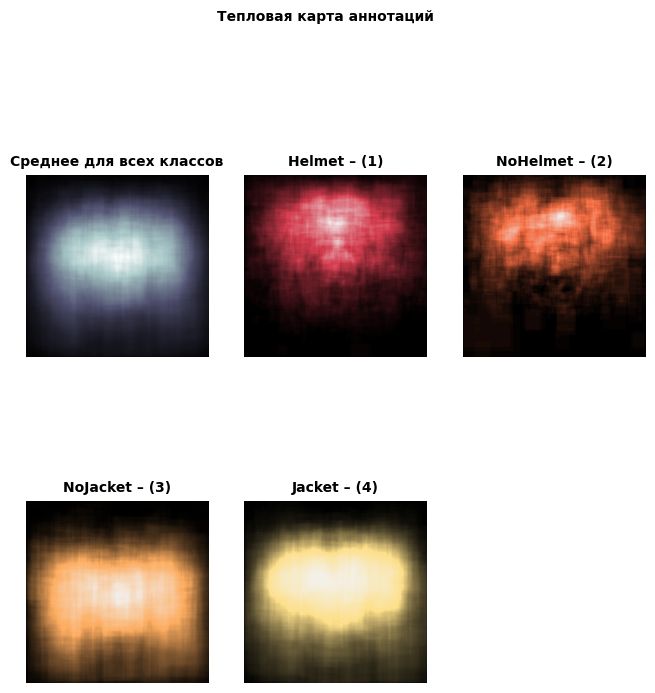

In [19]:
HEATMAP_SIZE = (640, 640, 4)

heatmap = np.zeros((HEATMAP_SIZE), dtype=np.int16)
bbox_np = df2[["classes", "frac_x_min", "frac_x_max", "frac_y_min", "frac_y_max"]].to_numpy()
bbox_np[:, 1:3] *= 640
bbox_np[:, 3:5] *= 640
bbox_np = np.floor(bbox_np).astype(np.int16)

custom_cmaps = [
    matplotlib.colors.LinearSegmentedColormap.from_list(
        colors=[(0.,0.,0.), c, (0.95,0.95,0.95)],
        name=f"custom_{i}") for i,c in enumerate(sns.color_palette("Spectral", 9))
]
custom_cmaps.pop(8)

for row in tqdm(bbox_np, total=bbox_np.shape[0]):
    heatmap[row[3]:row[4]+1, row[1]:row[2]+1, row[0]] += 1

fig = plt.figure(figsize=(8,12))
plt.suptitle("Тепловая карта аннотаций", fontweight="bold", fontsize=10)
for i in range(5):
    plt.subplot(3, 3, i+1)
    if i==0:
        plt.imshow(heatmap.mean(axis=-1), cmap="bone")
        plt.title(f"Среднее для всех классов", fontweight="bold", fontsize=10)
    else:
        plt.imshow(heatmap[:, :, i-1], cmap=custom_cmaps[i-1])
        plt.title(f"{class_id[i-1]} – ({i})", fontweight="bold", fontsize=10)

    plt.axis(False)
plt.show()

В общем, можно было и не строить тепловую карту, так как для данной задачи она совершенно неинформативна.

## Обработка аннотаций

И разбиение выборок на обучающую, валидационную и тестовую





In [20]:
classes = {'Helmet':0,'NoHelmet':1, 'NoJacket':2, 'Jacket':3}

In [21]:
!mkdir '/content/yolov5/labels'

In [22]:
for name in os.listdir('/content/yolov5/Construction/HardHat_2/data/Annotations'):
  with open('/content/yolov5/Construction/HardHat_2/data/Annotations/'+name, 'r') as file:
    xml_file = file.read()
    soup = BeautifulSoup(xml_file, 'xml')
    size = soup.find("size")
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    for tag in soup.findAll("object"):
      cls = tag.find("name").text
      xmin = int(tag.find("xmin").text)
      ymin = int(tag.find("ymin").text)
      xmax = int(tag.find("xmax").text)
      ymax = int(tag.find("ymax").text)

      w = xmax - xmin #вычисляем ширину бокса
      h = ymax - ymin #вычисляем высоту бокса
      x = xmin + (w / 2) #находим центр бокса по ширине
      y = ymin + (h / 2) #находим центр бокса по высоте

      #нормируем значения
      x = x / width
      w = w / width
      y = y / height
      h = h / height

      #записываем в файл
      with open('/content/yolov5/labels/'+name[:-3]+'txt', 'a') as f:
        f.write('{} {} {} {} {}\n'.format(classes[cls], x, y, w, h))

In [23]:
image_list = os.listdir('/content/yolov5/Construction/HardHat_2/data/Images')
train_list, test_list = train_test_split(image_list, test_size=0.2)
val_list, test_list = train_test_split(test_list, test_size=0.5)

print('Обучающая выборка: ',len(train_list))
print('Проверочная выборка: ',len(val_list))
print('Тестовая выборка:' ,len(test_list))

Обучающая выборка:  1734
Проверочная выборка:  217
Тестовая выборка: 217


In [24]:
!mkdir '/content/yolov5/images/'
!mkdir '/content/yolov5/images/'
!mkdir '/content/yolov5/images/train/'
!mkdir '/content/yolov5/images/valid/'

mkdir: cannot create directory ‘/content/yolov5/images/’: File exists


In [25]:
# !mkdir '/content/train/'
# !mkdir '/content/valid/'
# !mkdir '/content/train/images/'
# !mkdir '/content/valid/images'
# !mkdir '/content/train/labels'
# !mkdir '/content/valid/labels'

In [26]:
!mkdir '/content/yolov5/labels/train/'
!mkdir '/content/yolov5/labels/valid/'

In [27]:
def move_data(name_list, folder, newfolder, mode, img=True):
  """
  Функция перемещает файлы в указанную папку.
  name_list - список с названиями файлов для перемещения
  folder    - путь к папке откуда берем файл
  mode      - название папки куда перемещаем
  img       - указывает какой тип файла мы перемещаем
  """
  format = 'jpg' if img==True else 'txt'
  for name in name_list:
    name = name[:-3]+format
    # shutil.move(folder + name, folder + '{}/'.format(mode) + name)
    shutil.move(folder + name, newfolder + '{}/'.format(mode) + name)

In [28]:
move_data(train_list, '/content/yolov5/Construction/HardHat_2/data/Images/', '/content/yolov5/images/', 'train', img=True)
move_data(val_list, '/content/yolov5/Construction/HardHat_2/data/Images/', '/content/yolov5/images/', 'valid', img=True)

In [29]:
move_data(train_list, '/content/yolov5/labels/', '/content/yolov5/labels/', 'train', img=False)
move_data(val_list, '/content/yolov5/labels/', '/content/yolov5/labels/', 'valid', img=False)

## Загрузка и обучение модели Yolo_v5

In [30]:
yaml_file = {'train':'/content/yolov5/images/train',
             'val': '/content/yolov5/images/valid',
             'nc' : '4',
             'names' : ['Helmet', 'NoHelmet', 'NoJacket', 'Jacket']}

with open('helmet.yaml', 'w') as file:
    documents = yaml.dump(yaml_file, file)

In [40]:
!python train.py --img 640 --batch 32 --epochs 100 --data /content/yolov5/helmet.yaml --cfg models/yolov5m.yaml --weights yolov5m.pt

2023-12-03 18:56:13.460257: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 18:56:13.460324: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 18:56:13.460364: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/compat/__init__.py", line 42, in tf
ImportError: cannot import name 'notf' from 'tensorboard.compat' (/usr/local/lib/python3.10/dist-packages/tensorboard/compat/__init__.py)

During handling of the above exception, another exception occurred:

Traceback (most recent 

In [32]:
from PIL import Image
from matplotlib import pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

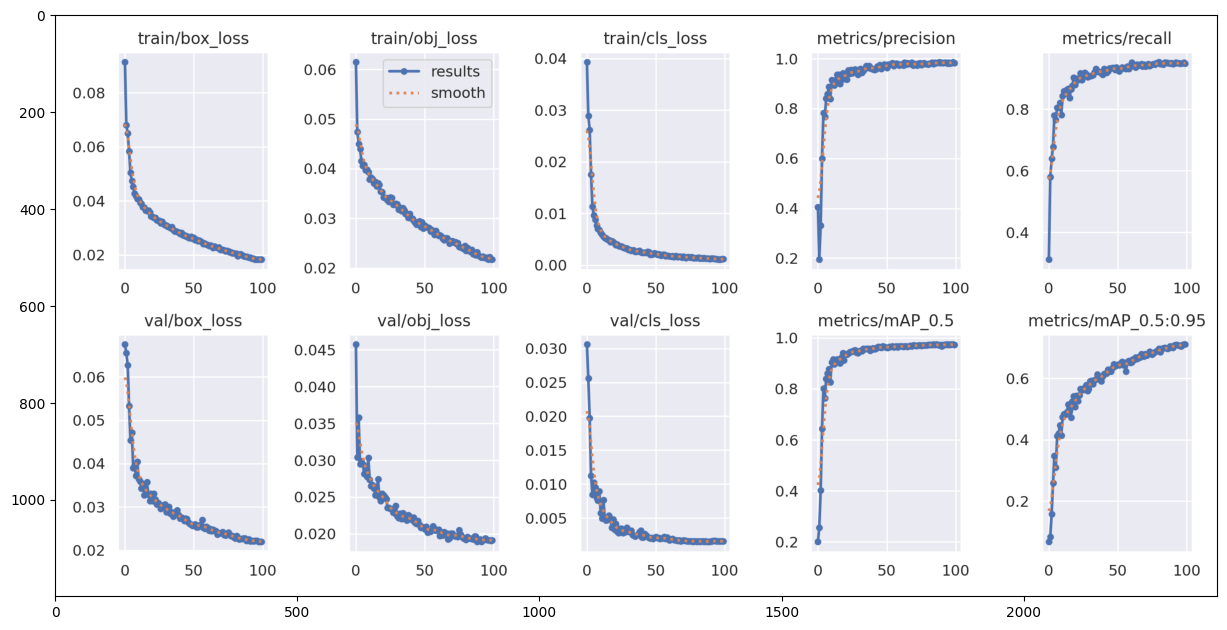

In [33]:
img = Image.open('/content/yolov5/runs/train/exp/results.png')
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.show

## Проверка на тестовой выборке

In [34]:
!mkdir '/content/yolov5/images/test/'
move_data(test_list, '/content/yolov5/Construction/HardHat_2/data/Images/', '/content/yolov5/images/', 'test', img=True)

In [41]:
!python detect.py --img 640 --source /content/yolov5/images/test/  --weights /content/yolov5/runs/train/exp/weights/best.pt --conf 0.25

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/yolov5/images/test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-247-g3f02fde Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20865057 parameters, 0 gradients, 47.9 GFLOPs
image 1/217 /content/yolov5/images/test/HardHat0330_jpg.rf.0b1d0e046c1a989963ab91bacf8c7add.jpg: 640x640 17 Helmets, 1 NoHelmet, 13 Jackets, 27.0ms
image 2/217 /content/yolov5/images/test/HardHat0331_jpg.rf.d8132abaf924938d16c7a18a37adedc1.jpg: 640x640 2 Helmets, 2 Jackets, 27.1ms
image 3/217 /content

## Выгрузка результатов

In [ ]:
!zip -r /content/file.zip /content/yolov5/runs/detect/exp/

In [37]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>